## Setting up the Python environment

You will need to install a bunch of modules for this E-tivity. While you're likely to already have numpy and matplotlib, you may need to install 'imageio' as well as 'tensorflow'. Perhaps the easiest way to install python packages is to use 'pip'. Additionally, you will likely need the 'pillow' module, which is a popular fork of the Python Imaging Library (PIL) for Keras image preparation.

**Make sure you have TF version >= 2.7.**

If you can run the following cell, then you should be fine:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import PIL # actually from the 'pillow' package

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.utils import image_dataset_from_directory, load_img

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


## CNNs, a brief introduction

We'll have a look at an important class of Deep Learning models known as Convolution Neural Networks, which amongst other things have led to great strides in image analysis and computer vision. Machine Learning has long been used for image analysis, specifically for feature detection or image classification:
- Optical Character Recognition (OCR)
- Handwriting recognition
- Automated image tagging
- Facial recognition

In particular, Artificial Neural Networks (ANN) have been routinely used for that purpose. The feed-forward approach has limits that CNNs have overcome using an idea from more traditional methods. The core idea is to apply a moving window filter to input data, that will be trained to extract small features (lines, curves, etc). These feature maps are then used to train the network with more filters to recognise bigger features (squares, triangles, circles, longer lines, etc) composed from the smaller ones. Finally, like in a traditional ANN, fully connect all the resulting data into a dense network and calculate outputs. The *convolution filters*, like the connections between neurons in the dense layers, are represented by a set of weights that will be adjusted through the training process, by minimising a loss function. This should sound familiar to you by now!

Note that while this approach is a natural fit for computer vision type problems and image classification is the most intuitive way to understand CNNs. However it is a generic Deep Learning architecture fit for many purposes: convolutions are just a tool to detect specific patterns from multidimensional numerical arrays, whether these represent images, time series or text. But since they are a great fit for images, this will be our use case for this E-tivity. Images make for a visually impressive demonstration of the power of the convolution operator, and they are more entertaining to work with than the functions and dots you have dealt with so far.

As an idea of the kind of tasks these models can accomplish, you may look at the [ImageNet database](http://www.image-net.org/) which contains images classified across over 20000 categories that include things such as strawberry, mayor or yo-yo. Modern CNN models (well, *enriched* CNNs) achieve less than 5% error in classification these days, to the point where ImageNet is no longer complex enough a task for AI and a 3d database of objects described through natural language is currently being developed as a new challenge.

## Task 1: Images as numbers

### Introduction
So far, we only ever dealt with numbers, but now, we want to deal with images. Thankfully, as far as the computer's concerned, digital images are numbers:
- At its core, an image is a numerical matrix, containing the colour values of each pixel at any given x/y coordinates.
- For a greyscale image, that number is the intensity of the pixel on a given scale: say 0 for pure black, 255 for pure white, and a number of grey shades in-between. Using floating point numbers, the scale could be between 0 (black) and 1 (white) instead. For example, this would be how the computer sees a 7 by 7 pixels black image with a white square outline:

$$\begin{vmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 255 & 255 & 255 & 255 & 255 & 0 \\
0 & 255 & 0 & 0 & 0 & 255 & 0 \\
0 & 255 & 0 & 0 & 0 & 255 & 0 \\
0 & 255 & 0 & 0 & 0 & 255 & 0 \\
0 & 255 & 255 & 255 & 255 & 255 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{vmatrix}$$

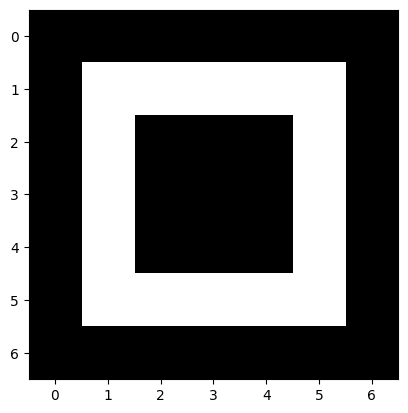

In [3]:
# let's define that simple figure as a matrix and plot it

# This is an empty white square on a black background.

plt.imshow(

    np.array(
    [[ 0,   0,   0,   0,   0,   0, 0 ],
     [ 0, 255, 255, 255, 255, 255, 0 ],
     [ 0, 255,   0,   0,   0, 255, 0 ],
     [ 0, 255,   0,   0,   0, 255, 0 ],
     [ 0, 255,   0,   0,   0, 255, 0 ],
     [ 0, 255, 255, 255, 255, 255, 0 ],
     [ 0,   0,   0,   0,   0,   0, 0 ]], dtype='uint8'),
    
    cmap='gray')

plt.show()

- For a colour image using the Red/Green/Blue (RGB) model, each pixel has one value for each colour channel, so you can picture the image as three numerical matrices: one for Red, one for Green, one for Blue. As such, a 7 by 7 pixels blue image with a red square outline would be represented as such:

Red Channel:
$$\begin{vmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 255 & 255 & 255 & 255 & 255 & 0 \\
0 & 255 & 0 & 0 & 0 & 255 & 0 \\
0 & 255 & 0 & 0 & 0 & 255 & 0 \\
0 & 255 & 0 & 0 & 0 & 255 & 0 \\
0 & 255 & 255 & 255 & 255 & 255 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{vmatrix}$$

Green Channel:
$$\begin{vmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{vmatrix}$$

Blue Channel:
$$\begin{vmatrix}
255 & 255 & 255 & 255 & 255 & 255 & 255 \\
255 & 0 & 0 & 0 & 0 & 0 & 255 \\
255 & 0 & 255 & 255 & 255 & 0 & 255 \\
255 & 0 & 255 & 255 & 255 & 0 & 255 \\
255 & 0 & 255 & 255 & 255 & 0 & 255 \\
255 & 0 & 0 & 0 & 0 & 0 & 255 \\
255 & 255 & 255 & 255 & 255 & 255 & 255 \\
\end{vmatrix}$$

So, what does this mean for our neural networks? Well, a black and white image of width $w$ and height $h$ is an array of $w\times h$ numbers. That means that if we design an ANN/CNN with $w\times h$ input nodes, we can feed our image as input, and calculate something from all those pixel values. For an RGB image, we'll need 3 times more input nodes.

### Coding tasks

- Complete the first two code cells below (replace the '???' blocks) by defining the 'red', 'green' and 'blue' variables so that executing the code produces the respective images:
 - an empty red square on a blue background
 - an empty yellow square on a pink/purple background (read up on the concept of [additive colour](https://en.wikipedia.org/wiki/Additive_color) if you are unfamiliar with it)
- Then plot the sum and difference of these images.
- Can you explain why the sum and difference you just plotted look like they do? Consider the fact that images are composed of unsigned integers (positive only).

Empty red square on blue background:


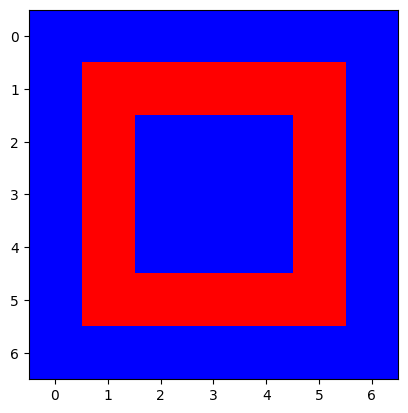

In [10]:
### Drawing an empty red square on a blue background
# define our R/G/B channels, combine them into a 3d array and plot them

red = np.array(
    [[ 0,   0,   0,   0,   0,   0, 0 ],
     [ 0, 255, 255, 255, 255, 255, 0 ],
     [ 0, 255,   0,   0,   0, 255, 0 ],
     [ 0, 255,   0,   0,   0, 255, 0 ],
     [ 0, 255,   0,   0,   0, 255, 0 ],
     [ 0, 255, 255, 255, 255, 255, 0 ],
     [ 0,   0,   0,   0,   0,   0, 0 ]], dtype='uint8')


green = np.array(
    [[ 0, 0,   0,   0,   0,   0, 0 ],
     [ 0, 0,   0,   0,   0,   0, 0 ],
     [ 0, 0,   0,   0,   0, 0, 0 ],
     [ 0, 0,   0,   0,   0, 0, 0 ],
     [ 0, 0,   0,   0,   0, 0, 0 ],
     [ 0, 0,   0,   0,   0,   0, 0 ],
     [ 0, 0,   0,   0,   0,   0, 0 ]], dtype='uint8')

blue = np.array(
    [[  255, 255, 255, 255, 255,  255, 255 ],
     [  255, 0,   0,   0,   0,   0, 255 ],
     [  255, 0, 255, 255, 255,  0, 255 ],
     [  255, 0, 255, 255, 255,  0, 255 ],
     [  255, 0, 255, 255, 255,  0, 255 ],
     [  255, 0,   0,   0,   0,   0, 255 ],
     [  255, 255, 255, 255, 255,  255, 255 ]], dtype='uint8')



rsq_blue = np.dstack([red, green, blue])

print("Empty red square on blue background:")
plt.imshow( rsq_blue )
plt.show()

Empty yellow square on pink background:


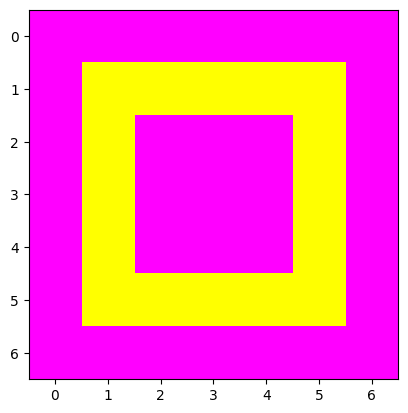

In [12]:
### Drawing an empty yellow square on a pink/purple background
# define our R/G/B channels, combine them into a 3d array and plot them

red = np.array(
    [[255, 255, 255, 255, 255, 255, 255],
 [255, 255, 255, 255, 255, 255, 255],
 [255, 255, 255, 255, 255, 255, 255],
 [255, 255, 255, 255, 255, 255, 255],
 [255, 255, 255, 255, 255, 255, 255],
 [255, 255, 255, 255, 255, 255, 255],
 [255, 255, 255, 255, 255, 255, 255]]
, dtype='uint8')


green = np.array(
    [[ 0,   0,   0,   0,   0,   0, 0 ],
     [ 0, 255, 255, 255, 255, 255, 0 ],
     [ 0, 255,   0,   0,   0, 255, 0 ],
     [ 0, 255,   0,   0,   0, 255, 0 ],
     [ 0, 255,   0,   0,   0, 255, 0 ],
     [ 0, 255, 255, 255, 255, 255, 0 ],
     [ 0,   0,   0,   0,   0,   0, 0 ]], dtype='uint8')

blue = np.array(
    [[  255, 255, 255, 255, 255,  255, 255 ],
     [  255, 0,   0,   0,   0,   0, 255 ],
     [  255, 0, 255, 255, 255,  0, 255 ],
     [  255, 0, 255, 255, 255,  0, 255 ],
     [  255, 0, 255, 255, 255,  0, 255 ],
     [  255, 0,   0,   0,   0,   0, 255 ],
     [  255, 255, 255, 255, 255,  255, 255 ]], dtype='uint8')



ysq_pink = np.dstack([red, green, blue])

print("Empty yellow square on pink background:")
plt.imshow( ysq_pink )
plt.show()

Sum of the two images:


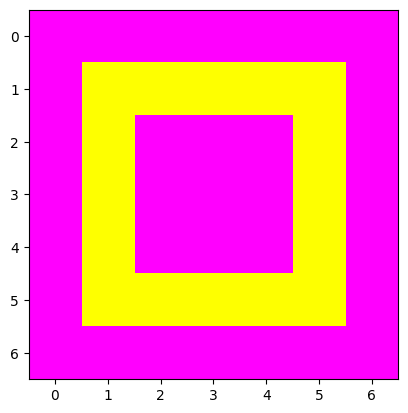

[[[255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]]

 [[255   0 254]
  [254 255   0]
  [254 255   0]
  [254 255   0]
  [254 255   0]
  [254 255   0]
  [255   0 254]]

 [[255   0 254]
  [254 255   0]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [254 255   0]
  [255   0 254]]

 [[255   0 254]
  [254 255   0]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [254 255   0]
  [255   0 254]]

 [[255   0 254]
  [254 255   0]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [254 255   0]
  [255   0 254]]

 [[255   0 254]
  [254 255   0]
  [254 255   0]
  [254 255   0]
  [254 255   0]
  [254 255   0]
  [255   0 254]]

 [[255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]]]
Difference of the two images:


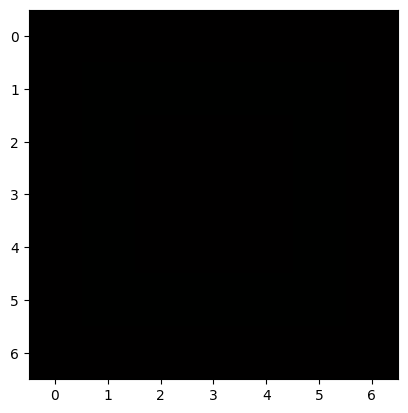

[[[1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [1 0 0]]

 [[1 0 0]
  [0 1 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [0 1 0]
  [1 0 0]]

 [[1 0 0]
  [0 1 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [0 1 0]
  [1 0 0]]

 [[1 0 0]
  [0 1 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [0 1 0]
  [1 0 0]]

 [[1 0 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [0 1 0]
  [1 0 0]]

 [[1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]
  [1 0 0]]]


In [13]:
### Plotting the sum and difference of the images

print("Sum of the two images:")
plt.imshow( rsq_blue + ysq_pink )
plt.show()
print(rsq_blue + ysq_pink)

print("Difference of the two images:")
plt.imshow( rsq_blue - ysq_pink )
plt.show()

print(rsq_blue - ysq_pink)

# TODO: explain the differences

In [15]:
print(rsq_blue + ysq_pink)

temp = rsq_blue + ysq_pink

red_images = temp[:,:,:,0]
green_images = temp[:,:,:,1]
blue_images = temp[:,:,:,2]

put_together = np.dstack([red_images, green_images, blue_images])

ysq_pink == put_together


[[[255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]]

 [[255   0 254]
  [254 255   0]
  [254 255   0]
  [254 255   0]
  [254 255   0]
  [254 255   0]
  [255   0 254]]

 [[255   0 254]
  [254 255   0]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [254 255   0]
  [255   0 254]]

 [[255   0 254]
  [254 255   0]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [254 255   0]
  [255   0 254]]

 [[255   0 254]
  [254 255   0]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [254 255   0]
  [255   0 254]]

 [[255   0 254]
  [254 255   0]
  [254 255   0]
  [254 255   0]
  [254 255   0]
  [254 255   0]
  [255   0 254]]

 [[255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]
  [255   0 254]]]


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

## Task 2: The convolution operation

### Introduction

Think of a simple perceptron where all input nodes are connected to a single output node, with no hidden layer. How many weights would we need to optimise to classify small images of 100 by 100 pixels? Well, since we have one input node per pixel and each input node will only require a single weight (only one node in the next layer), that's 100\*100, so 10000 weights. That is for a single output node, with no hidden layers... That's a lot of weights for a very limited network topology that won't be able to pickup many patterns. This is where convolutions come in.

In our context, the convolution operation is a simple operation based on a source image (actually it's numerical matrix representation) $I$ and a smaller matrix $K$ called a *convolution kernel*. We will drag that kernel across every $(i,j)$ pixel of the source image, and do an elementwise multiplication between the $I$ and $K$ terms before summing up all the terms. The result will be the value of the $(i,j)$ element in our result, called an *activation map*.

**Example:** say we have the following 5x5 pixel grid
$$\begin{vmatrix}
1 & 2 & 3 & 4 & 5\\
6 & 7 & 8 & 9 & 10\\
11 & 12 & 13 & 14 & 15\\
16 & 17 & 18 & 19 & 20\\
21 & 22 & 23 & 24 & 25\\
\end{vmatrix}$$

and we want to calculate the convolved value of the (2,2) pixel that has a value of 7 with the following convolution kernel:

$$\begin{vmatrix}
0 & 1 & 2 \\
1 & 2 & 0 \\
2 & 0 & 0 \\
\end{vmatrix}$$

We match the kernel to the pixel grid so that it is centered over the (2,2) pixel and add the respective kernel/pixel multiplied values:

$$0\times1+1\times2+2\times3+1\times6+2\times7+0\times8+2\times11+0\times12+0\times13=50$$

The convolved value of the (2,2) pixel is therefore 50.

You may notice that we will have a problem calculating values on the edges, since the kernel will be partly outside of the boundaries of the source image. We solve this by either:
- having an activation map that is smaller than the source image (it will be only as big as what we can calculate).
- doing some *padding*: using values of 0 or 1 or something else everywhere we need an out of bounds value.

The figure below illustrates the convolution process over a 4x4 grid of pixel values and a 3x3 convolution kernel, as well as zero-padding:

![Applying a convolution kernel. The bottom example illustrates zero-padding to allow edge values to be calculated.](images/convolution.png)

### Coding tasks

The test below loads a RGB image (3 channels, each one a 2d array of pixel intensities) as a [numpy n-dimensional array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html) and extracts a single channel. It then calls a convolution function a few times with different kernels before displaying the resulting activation map. You must:
- Implement a generic *Convolve(image,kernel,padding,pad_value)* function that will take any square $n \times n$ kernel with a stride of 1. Be able to add multiple padding columns and rows with a custom value.
- If this is to hard then the functionality can be reduced.
- The minimum functionality should be to implement a $3 \times 3$ kernel with a stride of 1 and no padding.
- Demonstrate its use with different kernels and padding (if applicable).

In [ ]:
# convolution function for source 2d array with nxn kernel, 
# with a number of padding rows/columns (can be 0)
# padding pixels = pad_value

def Convolve(image, kernel, padding, pad_value):

    

    return feature_map


In [ ]:
### Test code

def showimage(im):
    plt.imshow(im, cmap='gray')
    plt.colorbar()
    plt.show()
    
    
# read source RGB image as 3 channel image and strip out a single channel
img = imageio.imread('images/ulcrest_small.png')[:,:,1] # strip out one channel: 0=red, 1=green, 2=blue

print("Source image:")
print(img.shape)
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

# define various 2d convolution kernels
kernel_1 = np.array(
    [[ .1, .1, .1 ],
     [ .1, .2, .1 ],
     [ .1, .1, .1 ]], dtype='float32')

kernel_2 = np.array(
    [[ -1,  0,  1 ],
     [ -1,  0,  1 ],
     [ -1,  0,  1 ]], dtype='float32')

kernel_3 = np.array(
    [[ -1, -1, -1 ],
     [  0,  0,  0 ],
     [  1,  1,  1 ]], dtype='float32')

kernel_4 = np.array(
    [[  0, -1,  0 ],
     [ -1,  4, -1 ],
     [  0, -1,  0 ]], dtype='float32')



# convolve and display
activationmap_1 = Convolve(img, kernel_1, 0, 0)
print("Activation map #1 (kernel 1):")
print(activationmap_1.shape)
showimage(activationmap_1)

activationmap_2 = Convolve(img, kernel_2, 0, 0)
print("Activation map #2 (kernel 2):")
print(activationmap_2.shape)
showimage(activationmap_2)

activationmap_3 = Convolve(img, kernel_3, 0, 0)
print("Activation map #3 (kernel 3):")
print(activationmap_3.shape)
showimage(activationmap_3)

activationmap_4 = Convolve(img, kernel_4, 0, 0)
print("Activation map #4 (kernel 4):")
print(activationmap_4.shape)
showimage(activationmap_4)

activationmap_5 = Convolve(activationmap_2, kernel_3, 0, 0)
print("Activation map #5 (kernel 2 then kernel 3):")
print(activationmap_5.shape)
showimage(activationmap_5)


## Task 3 Pooling

### Introduction
We have seen how a small convolution kernel can transform an image into an activation map which highlights specific features. By implementing a number of convolution operations in a neural network before linking up all pixels together in a dense neural net layer, we can therefore train our network to optimise the weights in the convolution kernels so that loss is reduced. This will naturally converge towards kernels that highlight features that significantly correlate with the regression/classification task at hand, and do so efficiently from a computational point of view as we optimise far fewer weights in a convolution layer (only as many as the number of weights required by the kernel) than if we were to connect all pixels to a traditional hidden layer.

Still, at some point, we will want to connect all the pixels from our final activation map together into traditional dense layers (think "hidden layers"). This will still be expensive if the input activation map is too large. It will be even worse if we decide to expand our input into several activation maps, so that different maps capture different features to later correlate together. Also, it won't be generic enough as different weights will need to be optimised to capture the same features in different areas of the image.

In a CNN model, these issues are addressed through *pooling* (also called down-sampling). Pooling consists in reducing chunks of the source data into single data points. Say you take a 2x2 pixel area of the image, and reduce that to a single pixel, using the max value from those 4 pixels as the new value. Then you move that 2x2 window 2 pixels across and repeat the process. When you have done an entire line of the image, you move 2 pixels down and continue, until you're done. What you have done is known as a 2 by 2 (pooling window size) max-pooling (strategy to calculate new value from the ones under the window) operation with a stride of 2 (by how many pixels you shift your window each time).

The following figure illustrates a 2x2 max-pooling with stride 2 over a 4x4 image grid:
![2x2 pooling example with stride 2](images/pooling_stride2.png)

With a stride value equal to the size of the pooling window, all pooled regions are mutually exclusive. By comparison, the following figure illustrates a 2x2 max-pooling with stride 1 over the same image grid, in which case the pooling windows have some intersections:
![2x2 pooling example with stride 1](images/pooling_stride1.png)

In addition to drastically reducing the size of the data, the max-pooling process demonstrated here will be *translation-invariant*. If an activation map has higlighted (high numerical value) a feature in the top left corner of the image, then the top left corner of the pooled image will still carry this high value.

### Coding tasks

The test below calls a pooling function a few times, displaying the resulting pooled image each time. You can use the same original images as previously. You must:

- Implement a generic maxpooling function *Maxpooling(image, h, w, sx, sy)* that with take a kernel of any size $w \times h$ and with independent strides $s_x$ and $s_y$.
- If this is too difficult then the functionality can be reduced. 
- The minimum functionality is a maxpooling layer with $2 \times 2$ kernel with a stride of 2 in both directions.
- Demonstrate it with different kernels and strides (if applicable).

In [ ]:
# Max-pooling function for a hxw window size with a stride of sx,sy

def Maxpooling(image, h, w, sx, sy):

    return feature_map



In [ ]:
### Test code

# read source RGB image and take a single channel
img = imageio.imread('images/ulcrest_small.png')[:,:,1] # 0=red, 1=green, 2=blue
print(img.shape)
print("Source image:")
print(img.shape)
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

# run a few pooling operations and display the result

# max pool and display
pooled_1 = Maxpooling(img, 2, 2, 2, 2)
print(pooled_1.shape)
print("Pooling #1:")
plt.imshow(pooled_1, cmap='gray')
plt.colorbar()
plt.show()

pooled_2 = Maxpooling(pooled_1, 2, 2, 2, 2)
print(pooled_2.shape)
print("Pooling #2:")
plt.imshow(pooled_2, cmap='gray')
plt.colorbar()
plt.show()

pooled_3 = Maxpooling(pooled_2, 2, 2, 2, 2)
print(pooled_3.shape)
print("Pooling #3:")
plt.imshow(pooled_3, cmap='gray')
plt.colorbar()
plt.show()

pooled_4 = Maxpooling(pooled_3, 2, 2, 2, 2)
print(pooled_4.shape)
print("Pooling #4:")
plt.imshow(pooled_4, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
# max pool and display
pooled_1 = Maxpooling(img, 4, 4, 2, 2)
print("Pooling #1:")
print(pooled_1.shape)
plt.imshow(pooled_1, cmap='gray')
plt.colorbar()
plt.show()

pooled_2 = Maxpooling(pooled_1, 4, 4, 2, 2)
print("Pooling #2:")
print(pooled_2.shape)
plt.imshow(pooled_2, cmap='gray')
plt.colorbar()
plt.show()

pooled_3 = Maxpooling(img, 2, 3, 2, 3)
print("Pooling #3:")
print(pooled_3.shape)
plt.imshow(pooled_3, cmap='gray')
plt.colorbar()
plt.show()

pooled_4 = Maxpooling(pooled_3, 2, 3, 3, 2)
print("Pooling #4:")
print(pooled_4.shape)
plt.imshow(pooled_4, cmap='gray')
plt.colorbar()
plt.show()

## Task 4: Convolutional Neural Network

### Introduction
Over the course of the 3 E-tivities in this module, we have looked at all the individual pieces we need to build a convolutional neural network. Convolution layers can transform our input images into activation maps which highlight specific features, pooling allows us to reduce dimensionality while preserving important information in translation-invariant fashion, dense layers allow us to connect all the data together in traditional ANN fashion, and activation functions allow us to add some non-linearity to our model.

Both convolution and dense layers will contain a lot of weights that we will need to optimise, but we have seen how techniques such as gradient descent allow us to do that. Like a traditional ANN, a CNN will be trained through a sequence of forward step, loss calculation, then backward step and weight optimisation.

In these final tasks, we will use the Keras framework to setup a simple CNN topology to train a model to separate images of cats and dogs with minimal code.

Our model will implement the following layers:
- an input layer that accepts 3-channel (RGB) 64x64 images
- a convolution layer with 32 individual 3x3 convolution kernels, and a 'ReLU' activation function
- a 2x2 max-pooling layer with a stride of 2
- a 'flattening' layer that simply transforms our 32 activation maps into a flat numerical vector
- a dense layer (like an ANN hidden layer) with 128 nodes and a 'ReLU' activation function.
- a final dense layer as our output with a single node and a sigmoid activation (binary classification problem).

We will use the adam optimiser, binary crossentropy as a loss function, and we will want accuracy to be shown as a metric.

### Coding Tasks

The following cells contain incomplete Keras code where you will need to complete the '???' sections to get your model defined and trained. Follow the instructions above each cell and complete the code. You will need to consult the Keras documentation. A good starting point would be the [Sequential model guide](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential), and the [Image classification page](https://www.tensorflow.org/tutorials/images/classification).


In [ ]:
# define network topology
net = Sequential()

net.add(Input(???))
net.add(Rescaling(???))
net.add(Conv2D(???))
net.add(MaxPooling2D(???))
net.add(Flatten(???))
net.add(Dense(???))
net.add(Dense(???))

net.compile(optimizer = ???, loss = ???, metrics = ???)        

**Look at the model summary below and the sample size, does it seem resonable?**

In [ ]:
net.summary()

**Cell instructions:** Training and testing data has been prepared in advance, and can be found in the following folders:
- data/catdog/training_set/ contains two folders: cats/ and dogs/ which each contains individual jpeg images to be used for training.
- data/catdog/test_set/ contains two folders: cats/ and dogs/ which each contains individual jpeg images to be used for testing.

We'll use some of the Keras helper packages to turn those image folders into data sets that the model can use for training/testing. Setup the training and test sets with batches of 32. Complete the cell below according to those requirements:

In [ ]:
training_set = image_dataset_from_directory(???,
                                                 image_size = ???,
                                                 batch_size = ???)

test_set = image_dataset_from_directory(???,
                                            image_size = ???,
                                            batch_size = ???)

**Cell instructions:** fit your model on the training set over 10 epochs. Include the test set in the fitting process for validation.

In [ ]:
hist = net.fit(???)

- Below is how you can plot the loss and accuracy using the save stats from the model fitting.

- Possibly you can see that you have an overfitting model.

In [ ]:
plt.plot(hist.history['loss'],c='r')
plt.plot(hist.history['val_loss'],c='b')
plt.show()

plt.plot(hist.history['accuracy'],c='r')
plt.plot(hist.history['val_accuracy'],c='b')
plt.show()

## Task 5: Individual Task

You have now trained your first CNN, congratulations! Now experiment with the model topology there are no restrictions on layer types nor how many. Change hyperparameters and use [augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) to see if you can get towards 70% accuracy without overfitting.

This is quite a hard problem because you have a limited amount of data. However what is important is that you make rational decisions that will move you in that direction. The advise is to make incremental changes to the model and test it. Do not waste too much time trainng the model try 50-100 epochs per experiment.

**Remember do not submit this task to gitlab nor comment on the forum.**

### Visual Test

Below is a more visual test of your model with 4 unseen images.

In [ ]:
def classifyimage(imagepath,model):
    test_image = load_img(imagepath, target_size = (64, 64))
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)          
    if result[0][0] > 0.5:
        prediction = 'dog'
    else:
        prediction = 'cat'
    
    img = mpimg.imread(imagepath)
    plt.imshow(img)
    plt.show()
    print(prediction)

classifyimage('data/catdog/cat_or_dog_1.jpg',new_model)
classifyimage('data/catdog/cat_or_dog_2.jpg',new_model)
classifyimage('data/catdog/cat_or_dog_3.jpg',new_model)
classifyimage('data/catdog/cat_or_dog_4.jpg',new_model)

## Reflection
